In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from scipy.stats.distributions import t, norm

from arch import arch_model

import plotting
import backtesting as bt 

plt.style.use('seaborn-v0_8-whitegrid')


In [2]:
def get_q2_data():
    df =pd.read_csv('../data/QRM-2022-cw2-data.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', ascending=True)
    df.set_index('Date')
    df['logreturn'] = np.log(1 + df['TSLA'].pct_change())
    df['loss'] = -100*df['logreturn']
    df['max_loss'] = df['loss'].apply(lambda x: np.max([x,0]))
    df = df.iloc[1:,:]
    return df.set_index('Date')

In [3]:
df = get_q2_data()
train_mask = df.index < pd.to_datetime('26-11-2021', format='%d-%m-%Y')
train_df = df[train_mask]
test_df = df[~train_mask]

# 1i)

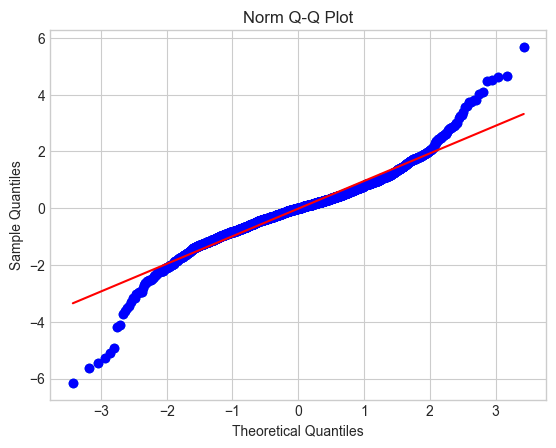

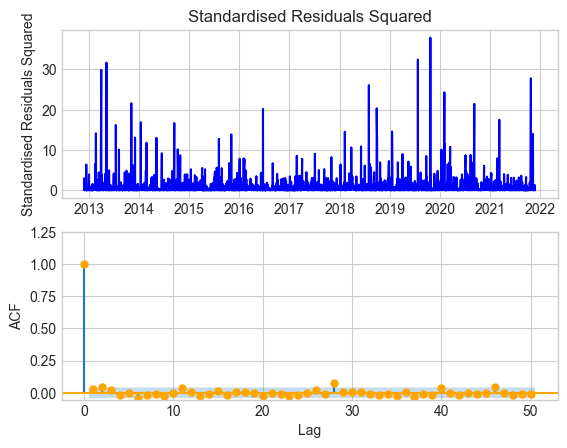

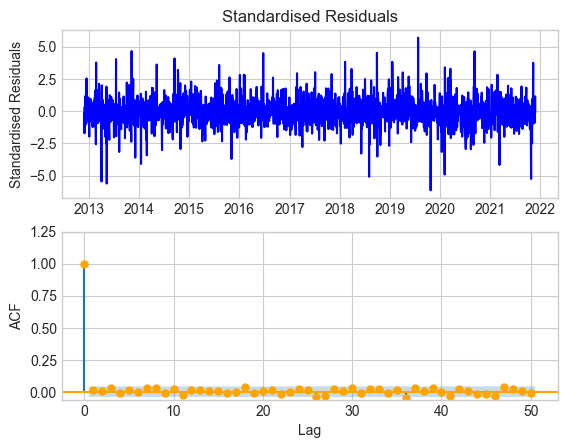

In [4]:

model = arch_model(train_df['loss'],
                    mean='constant', 
                    vol='GARCH', 
                    p=1, q=1, 
                    rescale=True, 
                    dist='normal'
                    )

model_fit_norm = model.fit(update_freq=-1, disp=0)

plotting.qqplot(model_fit_norm.std_resid, dist='norm')
plt.savefig('../plots/i/i_1.png'); plt.show()

plotting.plot_acf_graphs(model_fit_norm.std_resid**2, 'Standardised Residuals Squared')
plt.savefig('../plots/i/i_2.png'); plt.show()

plotting.plot_acf_graphs(model_fit_norm.std_resid, 'Standardised Residuals')
plt.savefig('../plots/i/i_3.png'); plt.show()



# 1ii)

dof=9.64970703125002


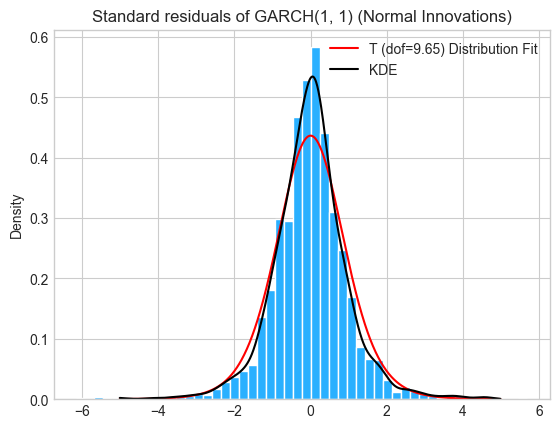

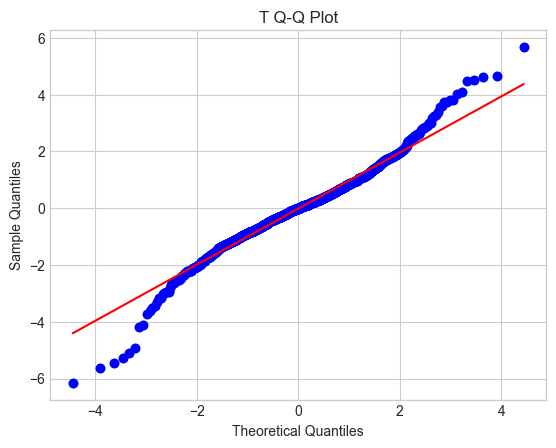

In [5]:
# fit t dist to residuals 
# We force the loc and scale as we are assuming the std residuals ~ SWN(0, 1)

dof, loc, scale = t.fit(model_fit_norm.std_resid, floc=0, fscale=1)
print(f"{dof=}")


t_dist_fit=t(df=dof, loc=loc, scale=np.sqrt((dof-2)/dof))


plotting.histogram_w_kde_and_dist(model_fit_norm.std_resid,
            title="Standard residuals of GARCH(1, 1) (Normal Innovations)",
            dist=t_dist_fit,
            dist_name=f'T ({dof=:.2f})')
plt.savefig('../plots/ii/ii_1.png')
plt.show()

plotting.qqplot(model_fit_norm.std_resid, dist=t_dist_fit); 
plt.savefig('../plots/ii/ii_2.png')
plt.show()


# 1iii)


#### Plan
- Create LL function for GPD with parameters $\beta$, $\xi$
- find a reasonable u from the data
- create $Y_{i} (:= X_{i}-u$) from the std_resid

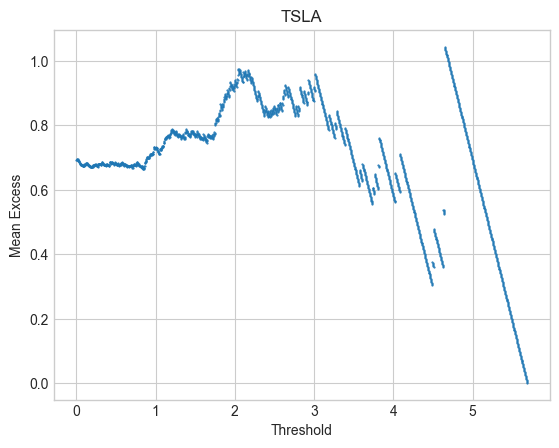

c:\Users\George\projects\masters\qrm2\venv\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
c:\Users\George\projects\masters\qrm2\src\backtesting.py:16: RuntimeWarning: divide by zero encountered in log
  first = -N*np.log(beta)
c:\Users\George\projects\masters\qrm2\src\backtesting.py:18: RuntimeWarning: invalid value encountered in double_scalars
  return first - second


xi=0.100
beta=0.661


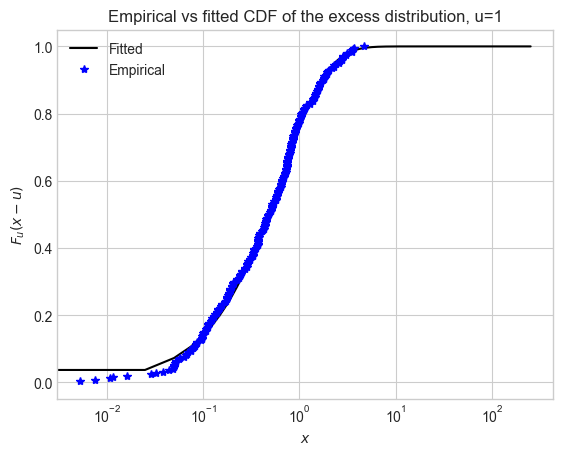

In [6]:

# plot mean excess
x = np.linspace(0, 30, 10001)
mean_excess_y = [bt.mean_excess(model_fit_norm.std_resid, y) for y in x]

ax = plt.scatter(x, mean_excess_y, s=0.3)
plt.xlabel('Threshold')
plt.ylabel('Mean Excess')
plt.title('TSLA');
plt.savefig('../plots/iii/iii_1.png')

plt.show()


# optimise for xi and beta, given u
u = 1
std_resid = model_fit_norm.std_resid
excess_dist = std_resid[std_resid>u] - u

xi, beta = bt.fit_gpd(model_fit_norm.std_resid, u=1)

print(f"{xi=:.3f}")
print(f"{beta=:.3f}")

plotting.plot_excess_dist(y=excess_dist, xi=xi, beta=beta, u=u); 
plt.savefig('../plots/iii/iii_2.png')
plt.show()

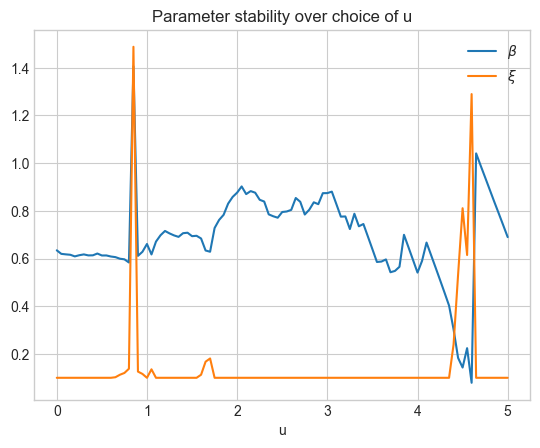

In [7]:
# check the stability of xis over choice of u
us = np.linspace(0, 5, 101)
xis_betas = np.array([bt.fit_gpd(std_resid, u) for u in us])

ax = plt.plot(us, xis_betas[:,1], label=r'$\beta$');
ax = plt.plot(us, xis_betas[:,0], label=r'$\xi$', );
plt.title("Parameter stability over choice of u")
plt.xlabel('u')
plt.legend()
plt.savefig('../plots/iii/iii_3.png')

plt.show()

# 1iv)

### Plan

- compute q values for standard normal (theoretical only)
- compute q values for T dist that we fitted in part ii
- compute q values for gpd that we fitted in iii. For this we need the empirical dist function for u


### Generate std forecasts for test set

In [8]:

# get model fit params
mu, alpha_0, alpha_1, beta_1 = model_fit_norm.params.to_numpy()
print(f"{mu=:.3f} ", f"{alpha_0=:.3f} ", f"{alpha_1=:.3f} ", f"{beta_1=:.3f} ")


# use params to forecast var for both in and out of sample
var = np.zeros_like(df['loss'].dropna())
var[0] = np.var(df['loss'].dropna(), ddof=1) # sample variance

# below is from model_fit_norm.conditional_volatility[0] (using the same starting point as the fitted model)
var[0]=1.833599**2


# Iteration over the GARCH(1,1) dynamics
for i in range(1, len(df['loss'].dropna())):
    var[i] = alpha_0 + alpha_1*(df['loss'].dropna()[i-1] - mu)**2 + (beta_1) * var[i-1]




df['std_forc'] = var**0.5
df['mu'] = mu

# # uncomment this to change to one 252 day forecast
# model_forecast = model_fit_norm.forecast(horizon=len(test_df))
# df.loc[~train_mask,'std_forc'] = (model_forecast.variance.iloc[-1,:]**0.5).to_numpy()
# df.loc[train_mask,'std_forc'] = (model_fit_norm.conditional_volatility).to_numpy()



#  std resid using each days std forecast (z_t = (x_t - mu)/std_forc )
df['z_t'] = (df['loss']-df['mu'])/df['std_forc']



mu=-0.151  alpha_0=0.139  alpha_1=0.041  beta_1=0.948 


In [9]:
alpha = 0.95
q_95_norm = norm().ppf(alpha)
es_95_norm_mult = norm().pdf(q_95_norm)/(1-alpha)

q_95_t = t_dist_fit.ppf(alpha)
es_95_t_mult = t_dist_fit.pdf(q_95_t)*(dof+q_95_t**2)/((1-alpha)*(dof-1))

q_95_par = bt.q_alpha_pareto(zs=model_fit_norm.std_resid, alpha=alpha, xi=xi, beta=beta, u=u)

es_95_par_mult = bt.es_pareto_mult(q=q_95_par, beta=beta, xi=xi, u=1)


alpha = 0.99
q_99_norm = norm().ppf(alpha)
es_99_norm_mult = norm().pdf(q_99_norm)/(1-alpha)

q_99_t = t_dist_fit.ppf(alpha)
es_99_t_mult = t_dist_fit.pdf(q_99_t)*(dof+q_99_t**2)/((1-alpha)*(dof-1))


q_99_par = bt.q_alpha_pareto(zs=model_fit_norm.std_resid, alpha=alpha, xi=xi, beta=beta, u=u)

es_99_par_mult = bt.es_pareto_mult(q=q_99_par, beta=beta, xi=xi, u=1)




### Calculate var assuming normal

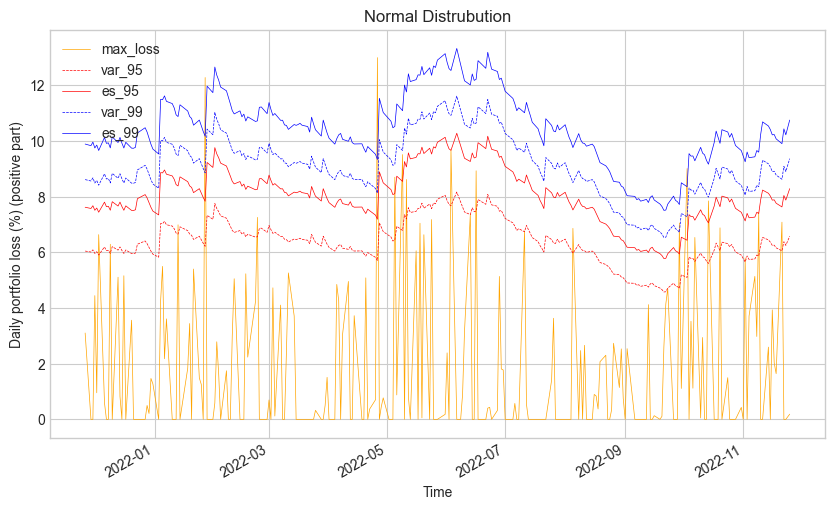

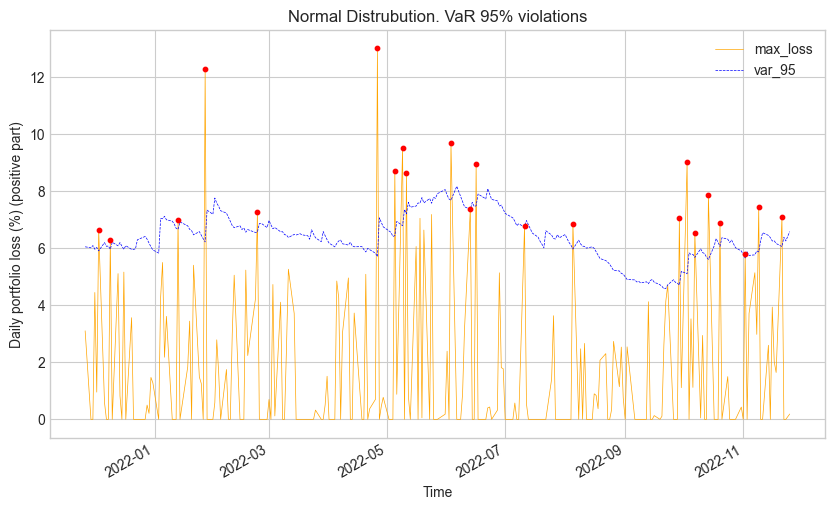

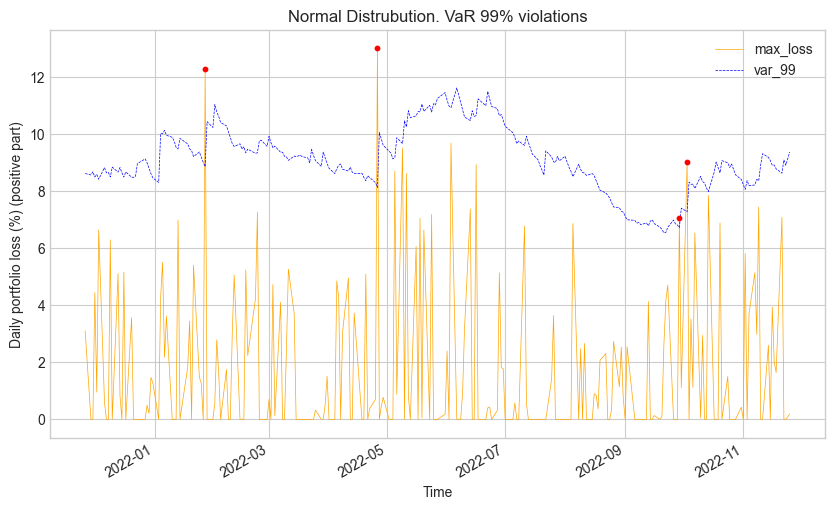

Violations 95%: 22, 8.73%
Violations 99%: 4, 1.59%


In [10]:
df_norm = bt.compute_var_df(df=df[~train_mask], q_95=q_95_norm, q_99=q_99_norm,
                         es_95_mult=es_95_norm_mult, es_99_mult=es_99_norm_mult)
bt.print_viols_and_plot(df_norm, 'Normal Distrubution',1)

### Calculate var assuming t

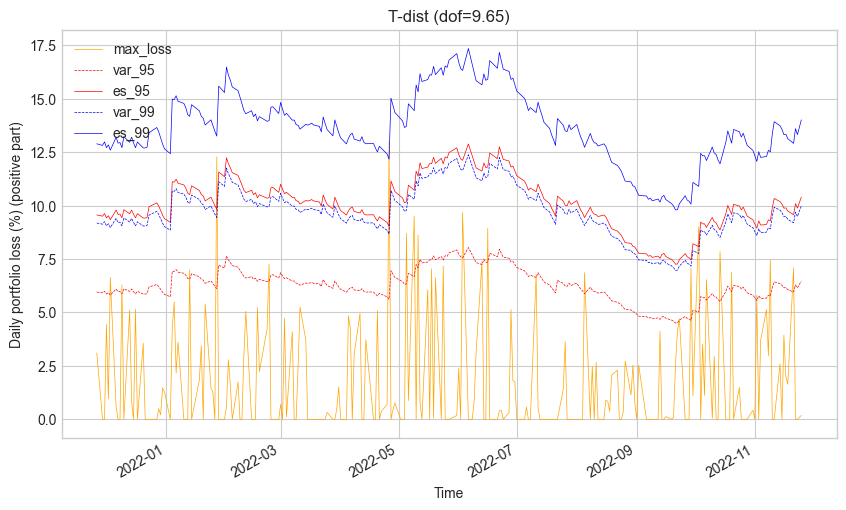

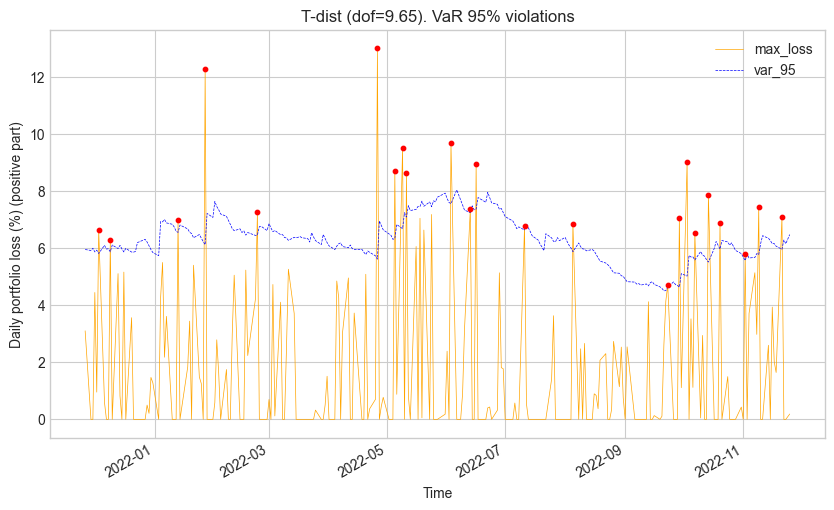

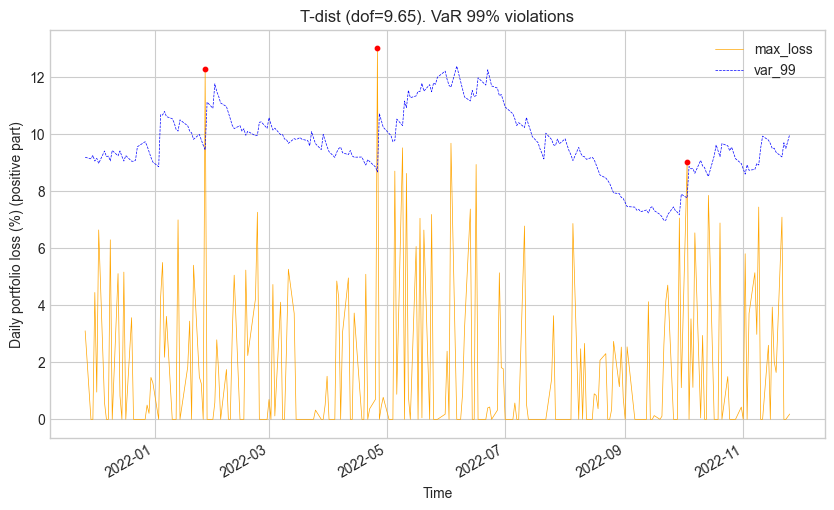

Violations 95%: 23, 9.13%
Violations 99%: 3, 1.19%


In [11]:
df_t = bt.compute_var_df(df=df[~train_mask], q_95=q_95_t, q_99=q_99_t,
                         es_95_mult=es_95_t_mult, es_99_mult=es_99_t_mult)
bt.print_viols_and_plot(df_t, f'T-dist (dof={dof:.2f})',2)

### Calculate var assuming pareto

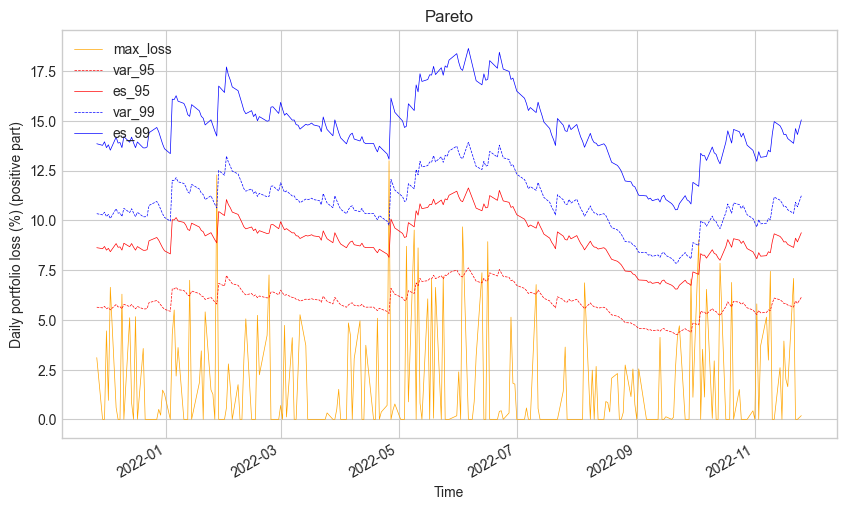

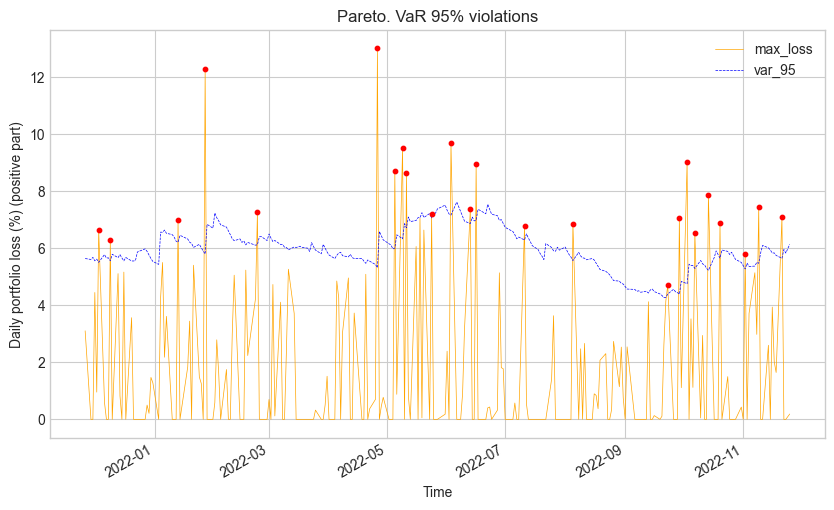

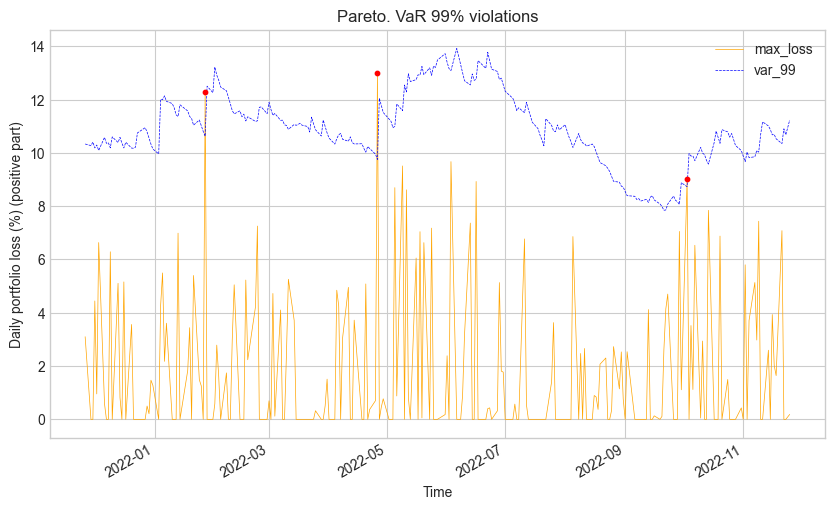

Violations 95%: 24, 9.52%
Violations 99%: 3, 1.19%


In [12]:
df_par = bt.compute_var_df(df=df[~train_mask], q_95=q_95_par, q_99=q_99_par,
                         es_95_mult=es_95_par_mult, es_99_mult=es_99_par_mult)
bt.print_viols_and_plot(df_par, 'Pareto',3)

In [13]:
backtesting_df = pd.concat(
        [bt.get_stats(df_norm, "Norm"),
        bt.get_stats(df_t, "T"),
        bt.get_stats(df_par, "Pareto")]
        ).reset_index(drop=True)
backtesting_df

,Title,Alpha,Violations (exp),LR_uc,LR_uc - p
0,Norm,0.95,22 (12.6),6.097,0.01354
1,Norm,0.99,4 (2.5),0.745,0.38804
2,T,0.95,23 (12.6),7.341,0.00674
3,T,0.99,3 (2.5),0.087,0.76797
4,Pareto,0.95,24 (12.6),8.681,0.00322
5,Pareto,0.99,3 (2.5),0.087,0.76797
